In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

In [2]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [3]:
df = pd.read_csv(
    r"C:\Users\Nguyên\OneDrive\Desktop\Portfolio project\sales_tbl.csv",
    parse_dates=["orderdate"],
    index_col="orderdate"
)
df.head()

,orderkey,linenumber,deliverydate,customerkey,storekey,productkey,quantity,unitprice,netprice,unitcost,currencycode,exchangerate,currentstock
orderdate,,,,,,,,,,,,,
2015-01-13,13005,0,1/13/2015,390139,90,147,3,2319.992,2134.39264,768.656,CAD,1.19657,801
2015-01-14,14000,1,1/14/2015,1185065,420,1904,2,674.250,674.25000,310.065,GBP,0.65843,800
2015-01-14,14002,1,1/14/2015,708902,280,2095,2,1106.250,1050.93750,366.525,EUR,0.84926,799
2015-01-14,14003,0,1/14/2015,591175,220,1660,2,173.994,173.99400,57.648,EUR,0.84926,800
2015-01-14,14003,2,1/14/2015,591175,220,1236,1,300.800,258.68800,153.360,EUR,0.84926,802


In [4]:
df["demand"] = df["unitprice"] * df["quantity"]

df_demand = df[["demand"]].copy()
df_demand["orderdate"] = df_demand.index

df_demand = df_demand[["orderdate", "demand"]]

print(df_demand.head())

            orderdate    demand
orderdate                      
2015-01-13 2015-01-13  6959.976
2015-01-14 2015-01-14  1348.500
2015-01-14 2015-01-14  2212.500
2015-01-14 2015-01-14   347.988
2015-01-14 2015-01-14   300.800


In [5]:
df_demand = df_demand.resample("MS")["demand"].sum()  # MS = Month Start

In [6]:
start_date = datetime(2015,1,1)
end_date = datetime(2024,1,1)
lim_df_demand = df_demand[start_date:end_date]

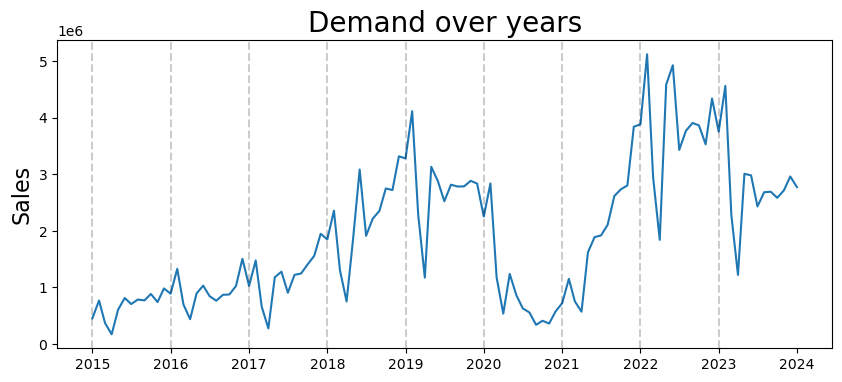

In [7]:
plt.figure(figsize=(10,4))
plt.plot(lim_df_demand)
plt.title('Demand over years', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [8]:
first_diff = lim_df_demand.diff()[1:]

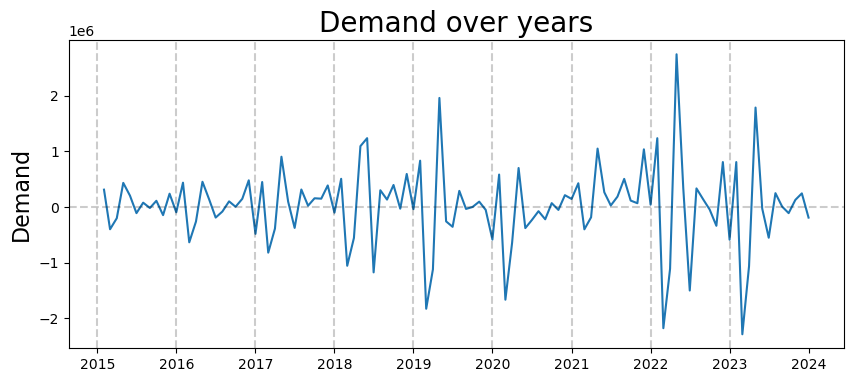

In [9]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Demand over years', fontsize=20)
plt.ylabel('Demand', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

<BarContainer object of 20 artists>

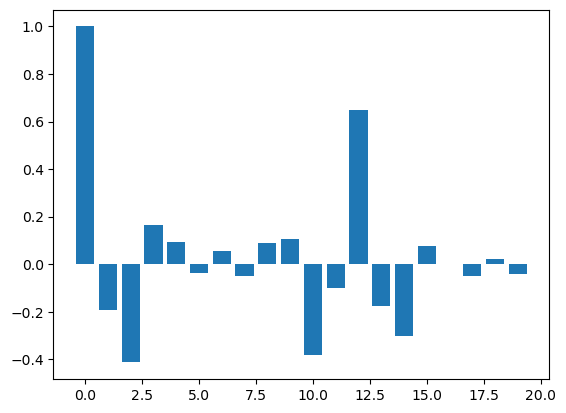

In [10]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

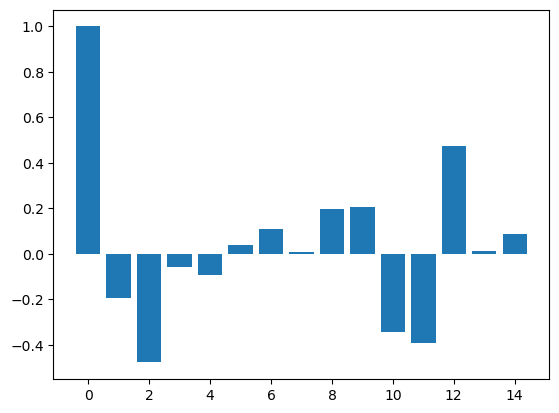

In [11]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [12]:
train_end = datetime(2023,3,1)
test_end = datetime(2024,3,1)

train_data = lim_df_demand[:train_end]
test_data = lim_df_demand[train_end + timedelta(days=1):test_end]

In [13]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [14]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.15378260612487793


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [15]:
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               demand   No. Observations:                   99
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1429.922
Date:                              Fri, 12 Sep 2025   AIC                           2865.845
Time:                                      19:45:22   BIC                           2873.600
Sample:                                  01-01-2015   HQIC                          2868.981
                                       - 03-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.9434      0.065     14.429      0.000       0.815       1.072
ma.S.L12      -0.60

In [16]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions

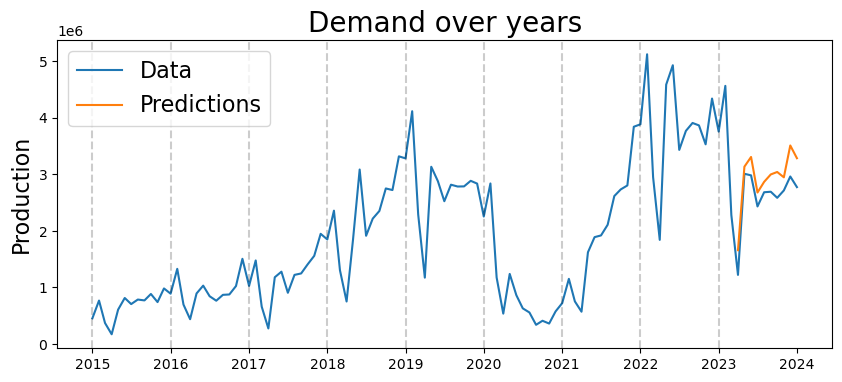

In [17]:
plt.figure(figsize=(10,4))

plt.plot(lim_df_demand)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Demand over years', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [18]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_df_demand[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Nguyên\AppData\Local\Temp\ipykernel_2648\1026018007.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Nguyên\AppData\Local\Temp\ipykernel_2648\1026018007.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
c:\ProgramData\anaco

In [19]:
rolling_residuals = test_data - rolling_predictions

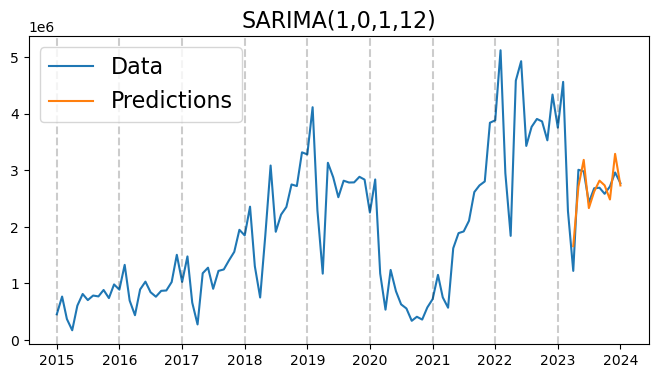

In [25]:
plt.figure(figsize=(8,4))

plt.plot(lim_df_demand)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('SARIMA(1,0,1,12)', fontsize=16)
plt.ylabel('', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)